In [2]:
from tectosaur2.nb_config import setup

setup()

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2.mesh import gauss_rule, stage1_refine
from tectosaur2.laplace2d import double_layer
from tectosaur2.integrate import integrate, Integral

300
[18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18]


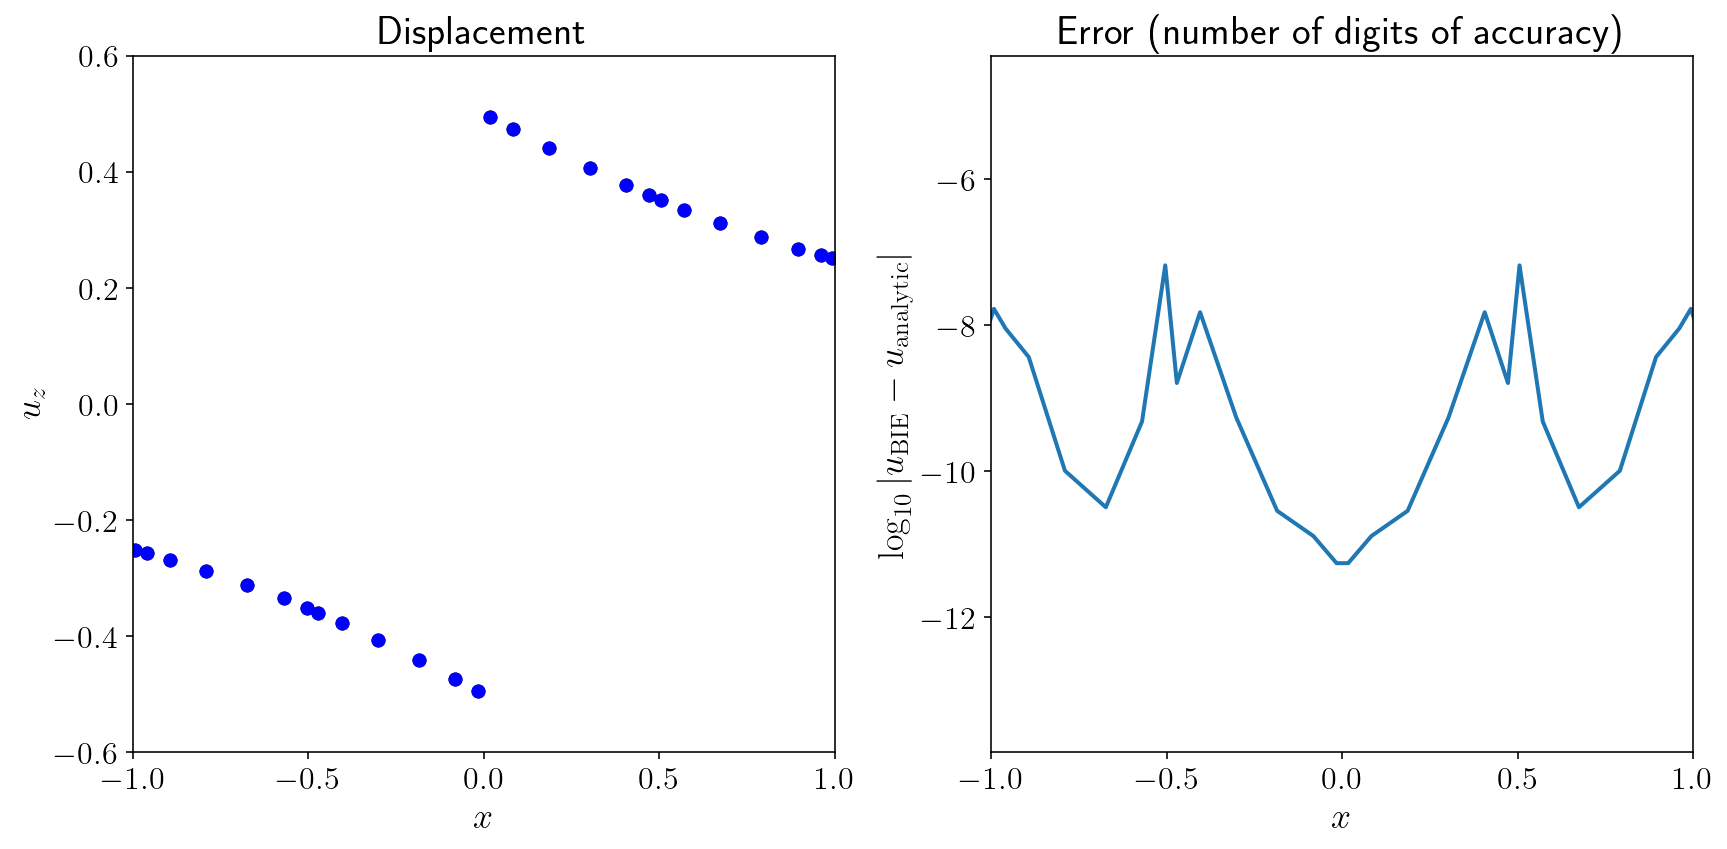

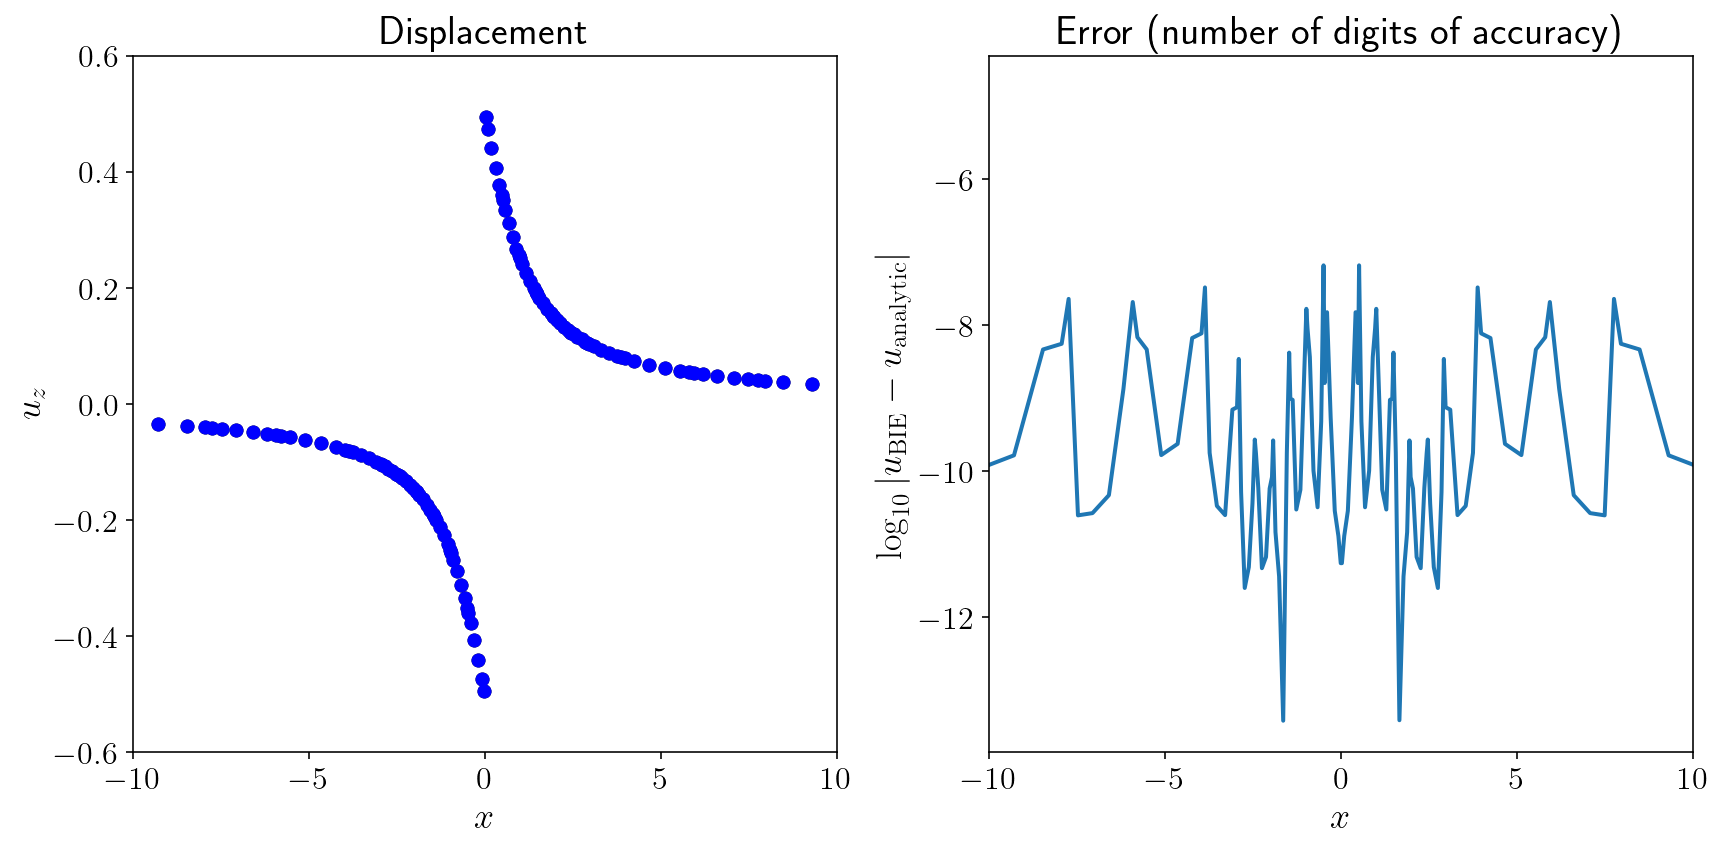

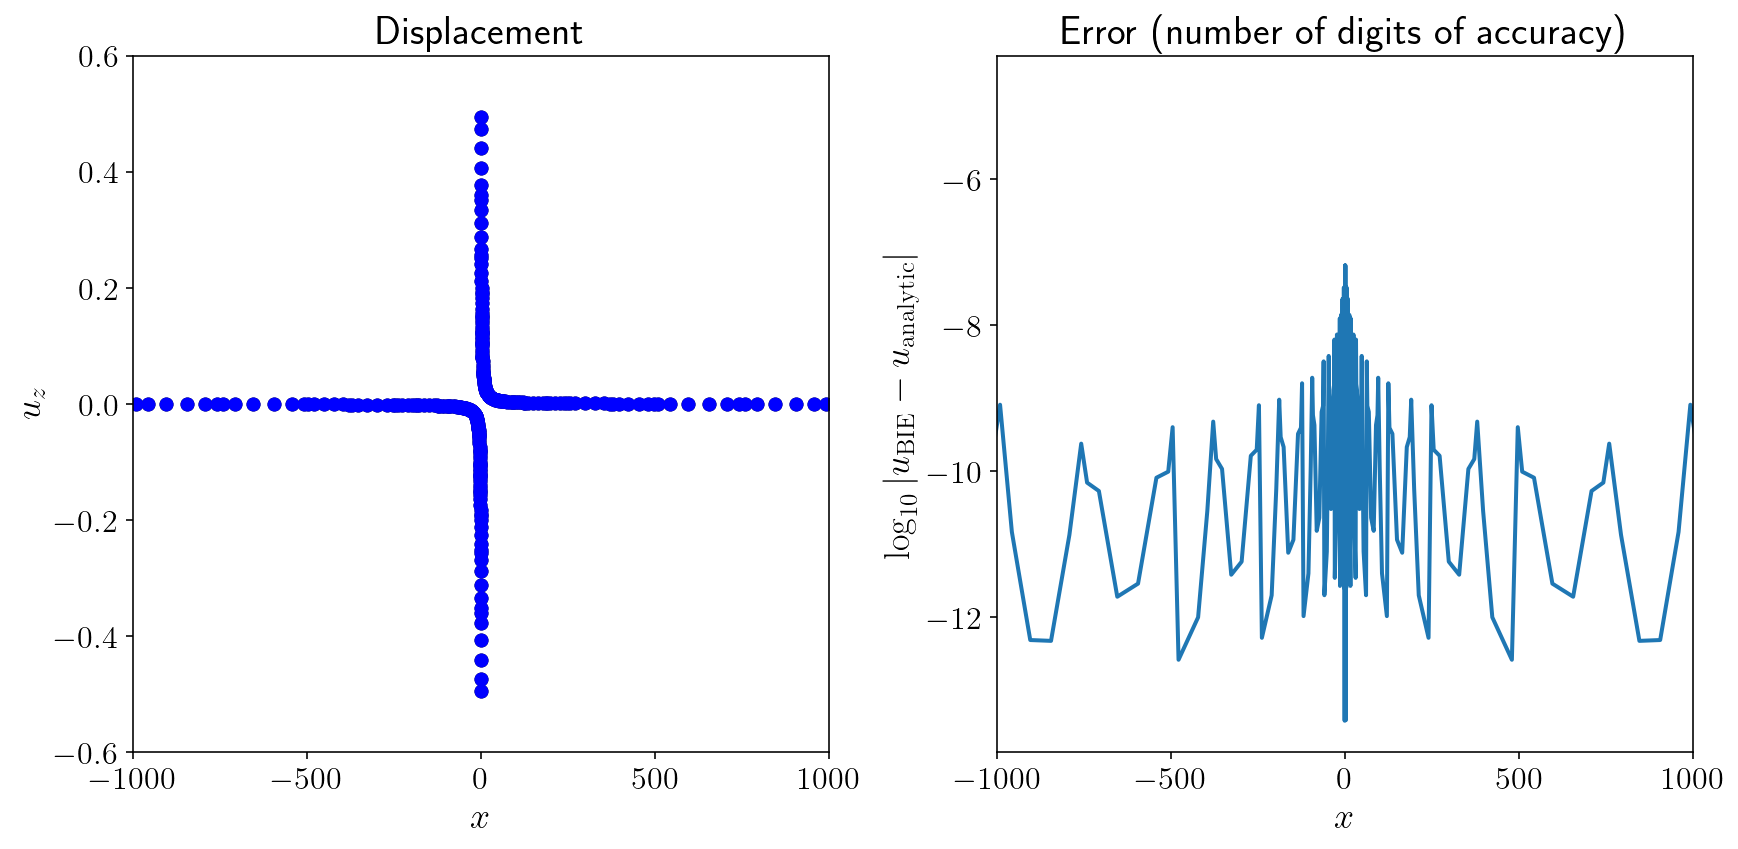

In [14]:
corner_resolution = 0.5
surf_half_L = 2000

qx, qw = gauss_rule(6)
t = sp.var("t")

fault, free = stage1_refine(
    [
        (t, t * 0, (t + 1) * -0.5),
        (t, -t * surf_half_L, 0 * t)
    ],
    (qx, qw),
    control_points=np.array([(0, 0, 2, corner_resolution)])
)
from tectosaur2.integrate import to_integrals
from tectosaur2.mesh import PanelSurface
obs_pts = free.pts
terms = to_integrals([(free, double_layer), (fault, double_layer)])

n_terms = len(terms)
n_obs = obs_pts.shape[0]

# TODO: NEED TO COMBINE THE SOURCE MESHES BEFORE INTEGRATING!!
# pts, quad_wts, jacobians, panel_length, panel_order, 
combined_src = PanelSurface(
    free.qx,
    free.qw,
    np.concatenate((free.quad_pts, fault.quad_pts)),
    np.concatenate((free.quad_wts, fault.quad_wts)),
    np.concatenate((free.pts, fault.pts)),
    np.concatenate((free.normals, fault.normals)),
    np.concatenate((free.jacobians, fault.jacobians)),
    np.concatenate((free.radius, fault.radius)),
    np.concatenate((free.panel_bounds, fault.panel_bounds)),
)
#TODO: 
from tectosaur2.integrate import Integral
DC = 2.5
DR = 16.0
(AB,), reports = integrate(
    free.pts, 
    Integral(combined_src, double_layer, max_p=18, d_cutoff=1.5, d_refine=DR), 
    #Integral(fault, double_layer, d_cutoff=DC, d_refine=DR), 
    return_reports=True
)
A = AB[:,0,:free.n_pts]
B = AB[:,0,free.n_pts:]
print(reports[0]['p'])
lhs = np.eye(A.shape[0]) + A
rhs = -B.dot(np.ones(fault.n_pts))
surf_disp = np.linalg.solve(lhs, rhs)

# Note that the analytical solution is slightly different than in the buried
# fault setting because we need to take the limit of an arctan as the
# denominator of the argument  goes to zero.
s = 1.0
analytical_fnc = lambda x: -np.arctan(-1 / x) / np.pi
analytical = analytical_fnc(free.pts[:,0])
%matplotlib inline
for XV in [1.0, 10, 1000]:
    # XV = 5 * corner_resolution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(free.pts[:, 0], surf_disp, "ko")
    plt.plot(free.pts[:, 0], analytical, "bo")
    plt.xlabel("$x$")
    plt.ylabel("$u_z$")
    plt.title("Displacement")
    plt.xlim([-XV, XV])
    plt.ylim([-0.6, 0.6])

    plt.subplot(1, 2, 2)
    plt.plot(free.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))
    plt.xlabel("$x$")
    plt.ylabel(r"$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
    plt.title("Error (number of digits of accuracy)")
    plt.tight_layout()
    plt.xlim([-XV, XV])
    plt.show()

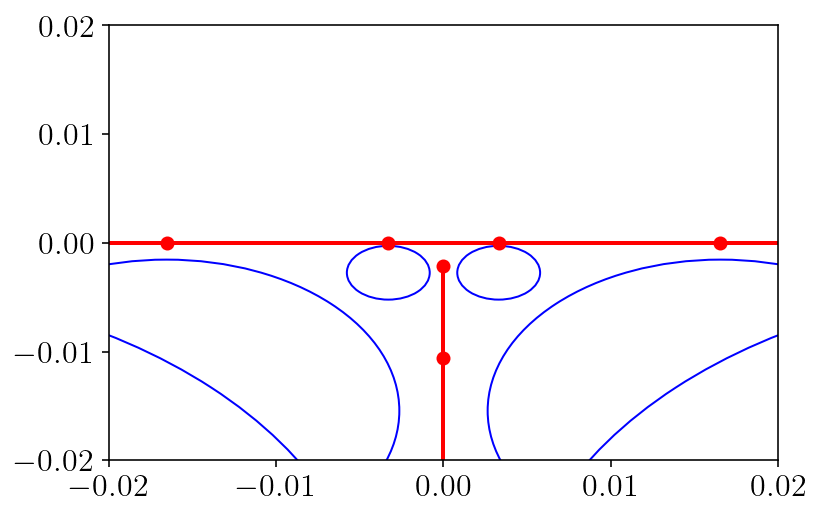

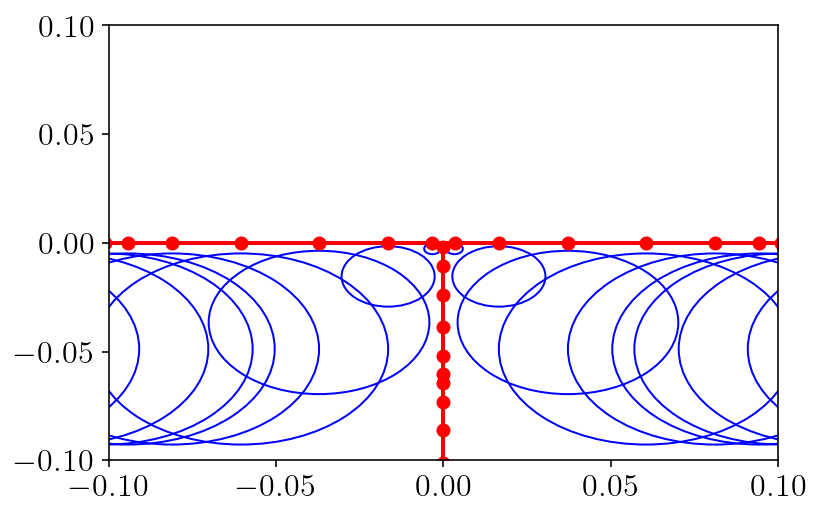

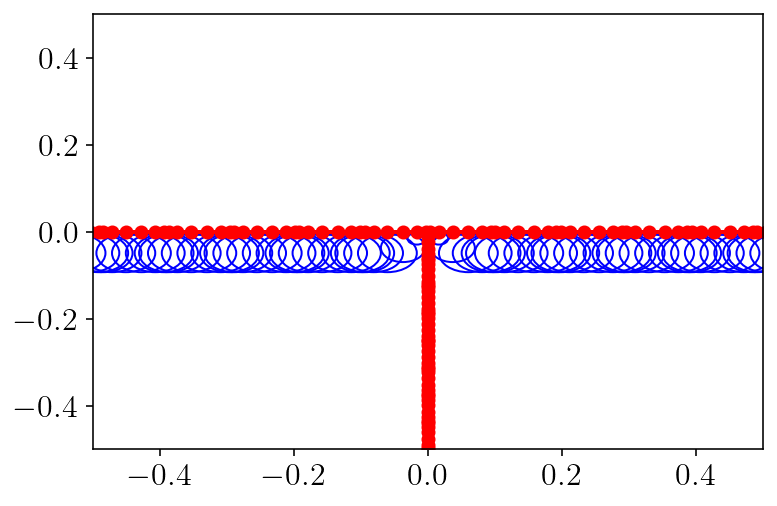

In [7]:
for V in [0.02, 0.1, 0.5]:
    cs = reports[0]['exp_centers']
    rs = reports[0]['exp_rs']
    plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-o')
    plt.plot(free.pts[:,0], free.pts[:,1], 'r-o')
    for i in range(cs.shape[0]):
        plt.gca().add_patch(plt.Circle(cs[i], rs[i], color='b', fill=False))
    plt.xlim([-V, V])
    plt.ylim([-V, V])
    plt.show()

remaining parameter list:
- $\kappa$
- qbx order $p$
- qbx distance $r$ (or in the code `mult`), probably just leave this as $L/2$ (where $L$ is the panel length)
- mesh refinement

The two remaining parameters are $\kappa$ and $r$. I've decided on $r=0.5*L_{panel}$, so the only remaining issue is to set $\kappa$ based on the error tolerance $\epsilon$. The relationship will look like $\kappa = f(\epsilon, \textrm{panel shape}, \textrm{kernel})$ because the panel shape and the choice of kernel will also drive the error function. I can look at the Klinteberg paper to get a sense of what the error estimate should look like. Then I can just empirically fit the constants in that error estimate based.

In [ ]:
surfs = []
solns = []
qx_ps = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

surf_half_L = 2000

for qx_p in qx_ps:
    qx, qw = gauss_rule(qx_p)
    t = sp.var("t")
    control_points = np.array([(0, 0, 2, corner_resolution)])
    fault = stage1_refine((t, t * 0, (t + 1) * -0.5), (qx, qw))
    flat = stage1_refine(
        (t, -t * surf_half_L, 0 * t), (qx, qw), other_surfaces=[fault], control_points=control_points
    )
    expansions = qbx_panel_setup(flat, other_surfaces=[fault], direction=1, p=15)
    fault_stage2, fault_interp_mat = stage2_refine(fault, expansions)
    flat_stage2, flat_interp_mat = stage2_refine(flat, expansions)
    A_raw = qbx_matrix(double_layer_matrix, flat_stage2, flat.pts, expansions)[:, 0, :]
    A = A_raw.dot(flat_interp_mat.toarray())
    B = -qbx_matrix(double_layer_matrix, fault_stage2, flat.pts, expansions)[:, 0, :]
    lhs = np.eye(A.shape[0]) + A
    rhs = B.dot(np.ones(fault_stage2.n_pts))
    surf_disp = np.linalg.solve(lhs, rhs)
    surfs.append(flat)
    solns.append(surf_disp)

In [ ]:
for i in range(len(qx_ps)):
    remove_end_idx = qx_ps[i] * 2
#     plt.plot(np.log10(np.abs(solns[i] - analytical_fnc(surfs[i].pts[:,0]))))
#     plt.show()
    diff = solns[i][remove_end_idx:-remove_end_idx] - analytical_fnc(surfs[i].pts[remove_end_idx:-remove_end_idx,0])
    l2_err = np.linalg.norm(diff)
    linf_err = np.max(np.abs(diff))
    print(qx_ps[i], l2_err, linf_err)